In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [2]:
from surp import subgiants
import surp
import vice
from surp import gce_math as gcem

In [3]:
from dataclasses import dataclass

In [4]:
def sfh_linexp(tau_sfh=5):
    return lambda t: t * np.exp(-t/tau_sfh)

In [33]:
def set_yields(tau_agb=0.3, t_d_agb=0.1, f_agb=0.2, agb_model="A"):
    if agb_model == "A":
        surp.yields.set_yields(
            agb_model="A", 
            zeta_cc=0, 
            f_agb=f_agb,
            verbose=False,
            a_agb_kwargs=dict(
                tau_agb = tau_agb,
                t_D = t_d_agb,
                zeta_agb = 0,
                
            
        ))
    else:
        surp.yields.set_yields(
            agb_model=model,
            verbose=False)
        

    
def sz_model(dt=0.01, t_end=13.2, tau_sfh=5, eta=0.5, tau_star=2, mode="gas", RIa="exp", **kwargs):
    
    set_yields(**kwargs)
    sfh = sfh_linexp(tau_sfh)
    sz = vice.singlezone(elements=["o", "mg", "c", "fe", "n"], func=sfh, mode=mode, dt=dt, 
                         eta=eta,  tau_star=tau_star, Mg0=1)
    
    sz.RIa = RIa
    out = sz.run(np.arange(0, t_end, dt), capture=True, overwrite=True)
    return out

In [34]:
sz = sz_model()

In [52]:
def calc_model(params):
    sz = sz_model(**params)
    zo_a = np.array(sz.history["z(o)"])[2:]
    zfe_a = np.array(sz.history["z(fe)"])[2:]
    zc_a = np.array(sz.history["z(c)"])[2:]

    o_h_a = gcem.abund_to_brak(zo_a, "o")
    c_o_a = gcem.abund_to_brak(zc_a/zo_a, "c", "o")
    o_fe_a = gcem.abund_to_brak(zo_a/zfe_a, "o", "fe")
    
    return o_fe_a, c_o_a, np.ones(len(o_h_a))

In [37]:
def prob(x, y, xerr, yerr, xm, ym):
    return np.exp(-1/2 * ((y - ym)**2/yerr**2 + (x-xm)**2/xerr**2))

In [38]:
def log_prob(obs, model):
    x, y, xerr, yerr = obs
    xm, ym, w = model
    xm = xm.reshape((-1, 1))
    ym = ym.reshape((-1, 1))
    w = w.reshape((-1, 1)) 
    Σs = np.sum(w * prob(x, y, xerr, yerr, xm, ym), axis=0) # sum over model
    return np.sum(np.log(Σs)) # return log product of each data point
    
    

    η: float = 0.5
    r: float = 0.4
    τ_star: float = 2
        
    t_d_agb: float = 0.1
    τ_agb: float = 0.1
        
    y_c_agb: float = vice.yields.agb.settings["c"].y0
    y_c_cc: float = vice.yields.ccsne.settings["c"].y0
    ζ_c_agb: float = vice.yields.ccsne.settings["c"].zeta
    ζ_c_cc: float = vice.yields.agb.settings["c"].zeta
        
    y_o = vice.yields.ccsne.settings["o"]
    y_fe_cc: float = vice.yields.ccsne.settings["fe"]
    y_fe_ia: float = vice.yields.sneia.settings["fe"]
        
    τ_ia: float = 1.5
    κ_ia: float = -1.1
    t_d_ia: float = 0.15
        
    t_end: float = 13.2

In [39]:
def normal(x, mu, sigma):
    return 1/np.sqrt(2*np.pi * sigma**2) * np.exp(-(x-mu)**2 / (2*sigma**2))

In [40]:
def log_normal(x, mu, sigma):
    return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)

In [41]:
x_m = np.linspace(-2, 5, 1000)

In [42]:
log_likelihoodparams(theta):
    eta, tau_agb, f_agb = theta
    
    return dict(eta=eta, tau_agb=tau_agb, f_agb=f_agb)


def log_prior(theta):
    params = get_params(theta)
    p = 0
    
    p += np.log(log_normal(params["eta"], 0.5, 2))
    p += np.log(log_normal(params["tau_agb"], 2, 0.5))
    p += np.log(normal(params["f_agb"], 0.2, 0.1))

    return p

def log_likelihood(theta, obs):
    params = get_params(theta)
    model = calc_model(params)
    return log_prob(obs, model) + log_prior(theta)

In [43]:
x = subgiants.MG_FE
y = subgiants.C_MG
xerr = subgiants.MG_FE_ERR
yerr = subgiants.C_MG_ERR

filt = ~np.isnan(x)
filt &= ~np.isnan(y)
filt &= ~np.isnan(xerr)
filt &= ~np.isnan(yerr)

x = x[filt].values
y = y[filt].values
xerr = xerr[filt].values
yerr = yerr[filt].values

obs = [x, y, xerr, yerr]

In [44]:
nll = lambda args, obs: -log_likelihood(args, obs)

th0 = [0.5, 0.3, 0.2]
Nparams = len(th0)

initial = th0 * (1 +  0.02 * np.random.randn(Nparams))
soln = minimize(nll, initial, args=obs)

/tmp/slurmtmp.26600102/ipykernel_174091/2286547979.py:8: RuntimeWarning: invalid value encountered in divide
  c_o_a = gcem.abund_to_brak(zc_a/zo_a, "c", "o")
/tmp/slurmtmp.26600102/ipykernel_174091/2286547979.py:9: RuntimeWarning: invalid value encountered in divide
  o_fe_a = gcem.abund_to_brak(zo_a/zfe_a, "o", "fe")


In [45]:
def plot_model(theta, **kwargs):
    params = get_params(theta)
    x, y, w = calc_model(params)
    plt.plot(x, y, **kwargs)

In [46]:
soln.x / initial

array([1., 1., 1.])

/tmp/slurmtmp.26600102/ipykernel_174091/2286547979.py:8: RuntimeWarning: invalid value encountered in divide
  c_o_a = gcem.abund_to_brak(zc_a/zo_a, "c", "o")
/tmp/slurmtmp.26600102/ipykernel_174091/2286547979.py:9: RuntimeWarning: invalid value encountered in divide
  o_fe_a = gcem.abund_to_brak(zo_a/zfe_a, "o", "fe")


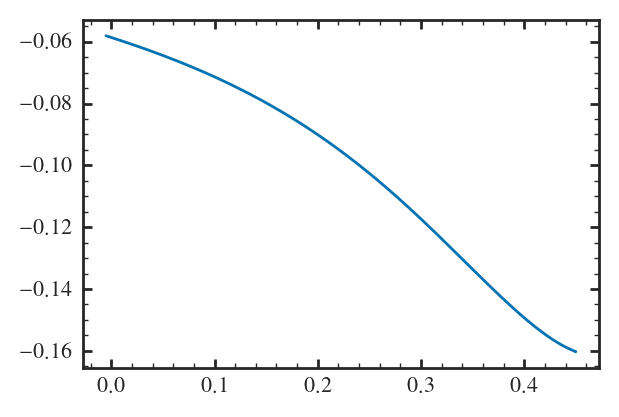

In [47]:
plot_model(soln.x)


/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/vice-1.4.0.dev2-py3.9-linux-x86_64.egg/vice/core/singlezone/singlezone.py:1850: VisibleRuntimeWarning: Functions of stellar mass and metallicity #for asymptotic giant branch star yields may significantly increase the #required integration time, especially for fine #timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/dill/_dill.py:1705: PicklingWarning: Cannot locate reference to <class 'vice.core.mlr.mlr'>.
  warnings.warn('Cannot locate reference to %r.' % (obj,), PicklingWarning)
/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/dill/_dill.py:1707: PicklingWarning: Cannot pickle <class 'vice.core.mlr.mlr'>: vice.core.mlr.mlr has recursive self-references that trigger a RecursionError.
  warnings.warn('Cannot pickle %r: %s.%s has recursive self-references that trigger a RecursionError.' % (obj, obj.__module__, obj_name), PicklingWarning)
/us

(-0.5, 0.2)

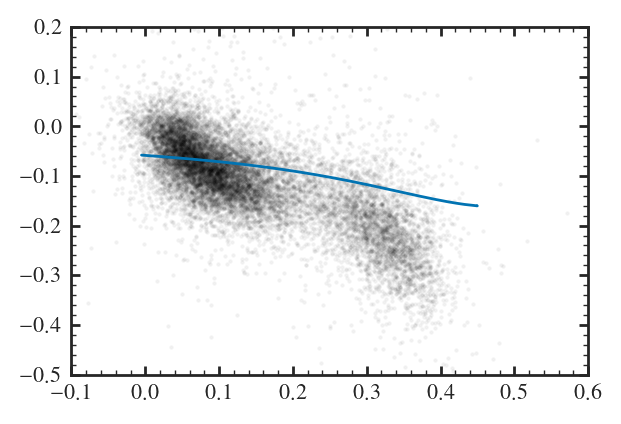

In [48]:
plt.scatter(x, y, s=0.3, alpha=0.05, color="k")
plot_model(soln.x)
plt.xlim(-0.1, 0.6)
plt.ylim(-0.5, 0.2)

In [ ]:
Nwalkers = 2*Nparams
pos = initial* (1 + 0.01 * np.random.randn(Nwalkers, Nparams))

sampler = emcee.EnsembleSampler(
    Nwalkers, Nparams, log_likelihood, args=[obs]
)
sampler.run_mcmc(pos, 100, progress=True)

  2%|▏         | 2/100 [03:24<2:42:52, 99.72s/it] 

In [ ]:
import corner

In [ ]:
flat_samples = sampler.get_chain(discard=10, thin=1, flat=True)

In [ ]:
fig = corner.corner(flat_samples, labels=[r"eta", "$tau_agb$", "$f_{\rm agb}$"]);

In [ ]:
sz_params()

In [ ]:
import arya

In [ ]:
arya.medianplot(subgiants, "MG_FE", "C_MG", binsize=100)

In [ ]:
for i in range(len(flat_samples)):
    plot_model(flat_samples[i, :], alpha=0.01, color="blue")

plt.scatter(x, y, s=0.3, alpha=0.05, color="k")
arya.medianplot(subgiants, "MG_FE", "C_MG", binsize=100)
plt.xlim(-0.1, 0.6)
plt.ylim(-0.5, 0.2)